## Inspect impact of explicit stochasicity

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt

DATADIR = 'data'
expcode = 'always_include_unbroken_1year'
ds_stochastic_gcm = xr.open_dataset(f'{DATADIR}/mima_gwf_{expcode}_stochastic.nc')
ds_determin_gcm = xr.open_dataset(f'{DATADIR}/mima_gwf_{expcode}.nc')
ds_stochnorm_gcm = xr.open_dataset(f'{DATADIR}/mima_gwf_{expcode}_normal_stochastic.nc')
ds_stochuni_gcm = xr.open_dataset(f'{DATADIR}/mima_gwf_{expcode}_uniform_stochastic.nc')


ds_stochastic_era5 = xr.open_dataset(f'{DATADIR}/era5_{expcode}_stochastic.nc')
ds_determin_era5 = xr.open_dataset(f'{DATADIR}/era5_{expcode}.nc')

ds_stochastic_gcm = ds_stochastic_gcm[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]
ds_determin_gcm = ds_determin_gcm[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]
ds_stochastic_era5 = ds_stochastic_era5[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]
ds_determin_era5 = ds_determin_era5[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]
ds_stochnorm_gcm = ds_stochnorm_gcm[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]
ds_stochuni_gcm = ds_stochuni_gcm[['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']]

In [2]:
from ad99py.loon import loon_data
LOON_DATA = loon_data(path='data/loon')
LOON_DATA.keys()

from ad99py.masks import mask_dataset
BASINS = None # All basins
basin_title = ""


def filter_scale(fluxes):
    fluxes = np.abs(fluxes)
    fluxes = fluxes[fluxes > 1e-8] # zeros mess with the PDF so lets remove these
    return fluxes*1000

 
masked_stochastic_gcm = mask_dataset(ds_stochastic_gcm.sel(level=50))
masked_deterministic_gcm = mask_dataset(ds_determin_gcm.sel(level=50))
masked_stochnorm_gcm = mask_dataset( ds_stochnorm_gcm.sel(level=50))
masked_stochuni_gcm = mask_dataset(ds_stochuni_gcm.sel(level=50))

masked_stochastic_era5 = mask_dataset(ds_stochastic_era5.sel(level=50))
masked_deterministic_era5 = mask_dataset(ds_determin_era5.sel(level=50))

In [3]:
eastward_flux_stoch_gcm = filter_scale(masked_stochastic_gcm.gw_flux_eastward.data.ravel())
eastward_flux_stoch_gcm_log10 = np.log10(eastward_flux_stoch_gcm)

eastward_flux_determ_gcm = filter_scale(masked_deterministic_gcm.gw_flux_eastward.data.ravel())
eastward_flux_determ_gcm_log10 = np.log10(eastward_flux_determ_gcm)

eastward_flux_stochnorm_gcm = filter_scale(masked_stochnorm_gcm.gw_flux_eastward.data.ravel())
eastward_flux_stochnorm_gcm_log10 = np.log10(eastward_flux_stochnorm_gcm)

eastward_flux_stochuni_gcm = filter_scale(masked_stochuni_gcm.gw_flux_eastward.data.ravel())
eastward_flux_stochuni_gcm_log10 = np.log10(eastward_flux_stochuni_gcm)

In [4]:
eastward_flux_stoch_era5 = filter_scale(masked_stochastic_era5.gw_flux_eastward.data.ravel())
eastward_flux_stoch_era5_log10 = np.log10(eastward_flux_stoch_era5)

eastward_flux_determ_era5 = filter_scale(masked_deterministic_era5.gw_flux_eastward.data.ravel())
eastward_flux_determ_era5_log10 = np.log10(eastward_flux_determ_era5)

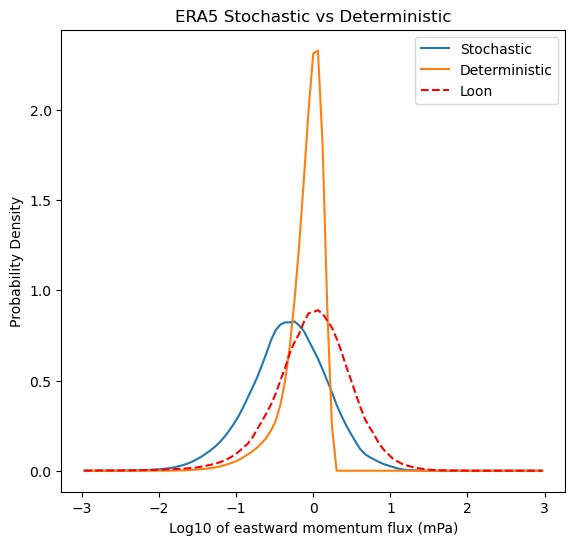

In [5]:
fig,ax = plt.subplots(1,1,figsize=(6.5,6))
log_bin_edge= np.linspace(-3,3,100,endpoint=True)
log_bin_center = 0.5*(log_bin_edge[1:] + log_bin_edge[:-1])

flux_bin, flux_edge = np.histogram(eastward_flux_stoch_era5_log10,bins=log_bin_edge,density=True)
determ_flux_bin, flux_edge = np.histogram(eastward_flux_determ_era5_log10,bins=log_bin_edge,density=True)

ax.plot(log_bin_center,flux_bin,label='Stochastic')
ax.plot(log_bin_center,determ_flux_bin,label='Deterministic')
ax.set_xlabel("Log10 of eastward momentum flux (mPa)")
ax.set_ylabel("Probability Density")
loon_flux_bin, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=log_bin_edge,density=True)
ax.plot(log_bin_center,loon_flux_bin,color='red',linestyle='--',label="Loon")
ax.set_title("ERA5 Stochastic vs Deterministic")
plt.legend()
plt.savefig(f'figures/{expcode}_stochastic_comparison_era5.png',dpi=300)

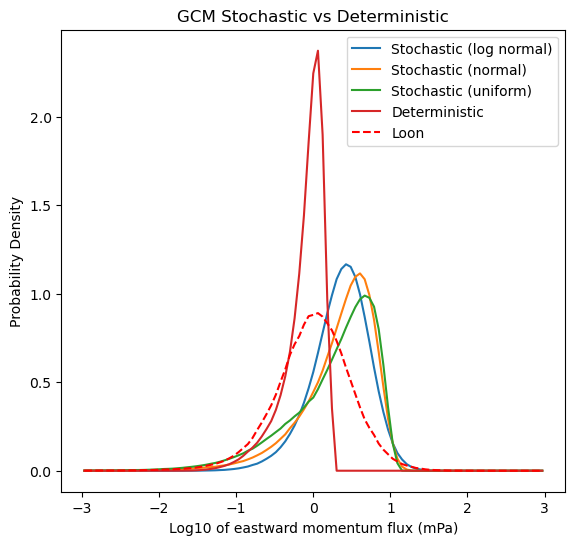

In [6]:
fig,ax = plt.subplots(1,1,figsize=(6.5,6))
log_bin_edge= np.linspace(-3,3,100,endpoint=True)
log_bin_center = 0.5*(log_bin_edge[1:] + log_bin_edge[:-1])

flux_norm_bin, _ = np.histogram(eastward_flux_stochnorm_gcm_log10,bins=log_bin_edge,density=True)
flux_uni_bin, _ = np.histogram(eastward_flux_stochuni_gcm_log10,bins=log_bin_edge,density=True)

flux_bin, flux_edge = np.histogram(eastward_flux_stoch_gcm_log10,bins=log_bin_edge,density=True)
determ_flux_bin, flux_edge = np.histogram(eastward_flux_determ_gcm_log10,bins=log_bin_edge,density=True)

ax.plot(log_bin_center,flux_bin,label='Stochastic (log normal)')
ax.plot(log_bin_center,flux_norm_bin,label='Stochastic (normal)')
ax.plot(log_bin_center,flux_uni_bin,label='Stochastic (uniform)')
ax.plot(log_bin_center,determ_flux_bin,label='Deterministic')
ax.set_xlabel("Log10 of eastward momentum flux (mPa)")
ax.set_ylabel("Probability Density")
loon_flux_bin, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=log_bin_edge,density=True)
ax.plot(log_bin_center,loon_flux_bin,color='red',linestyle='--',label="Loon")
ax.set_title("GCM Stochastic vs Deterministic")
plt.legend()
plt.savefig(f'figures/{expcode}_stochastic_comparison_gcm.png',dpi=300)

/tmp/ipykernel_13505/856478215.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


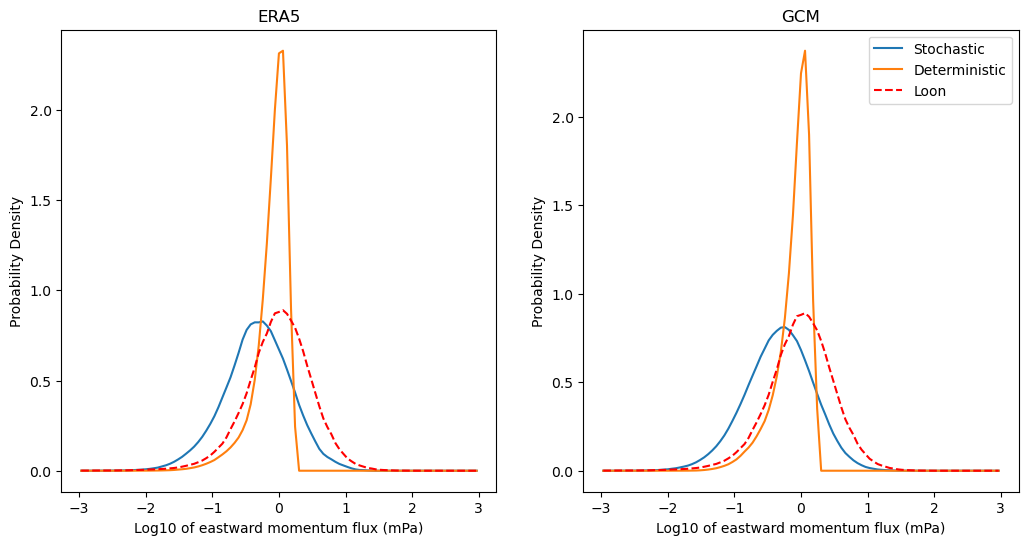

In [17]:
fig,(ax_era5,ax_gcm) = plt.subplots(1,2,figsize=(6.5*1.9,6))
log_bin_edge= np.linspace(-3,3,100,endpoint=True)
log_bin_center = 0.5*(log_bin_edge[1:] + log_bin_edge[:-1])

flux_bin, flux_edge = np.histogram(eastward_flux_stoch_era5_log10,bins=log_bin_edge,density=True)
determ_flux_bin, flux_edge = np.histogram(eastward_flux_determ_era5_log10,bins=log_bin_edge,density=True)

ax_era5.plot(log_bin_center,flux_bin,label='Stochastic')
ax_era5.plot(log_bin_center,determ_flux_bin,label='Deterministic')
ax_era5.set_xlabel("Log10 of eastward momentum flux (mPa)")
ax_era5.set_ylabel("Probability Density")
loon_flux_bin, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=log_bin_edge,density=True)
ax_era5.plot(log_bin_center,loon_flux_bin,color='red',linestyle='--',label="Loon")
ax_era5.set_title("ERA5")
plt.legend()

flux_bin, flux_edge = np.histogram(eastward_flux_stoch_gcm_log10,bins=log_bin_edge,density=True)
determ_flux_bin, flux_edge = np.histogram(eastward_flux_determ_gcm_log10,bins=log_bin_edge,density=True)

ax_gcm.plot(log_bin_center,flux_bin,label='Stochastic')
ax_gcm.plot(log_bin_center,determ_flux_bin,label='Deterministic')
ax_gcm.set_xlabel("Log10 of eastward momentum flux (mPa)")
ax_gcm.set_ylabel("Probability Density")
loon_flux_bin, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=log_bin_edge,density=True)
ax_gcm.plot(log_bin_center,loon_flux_bin,color='red',linestyle='--',label="Loon")
ax_gcm.set_title("GCM")
ax_gcm.legend()
plt.savefig(f'figures/{expcode}_stochastic_comparison_merged.png',dpi=300)

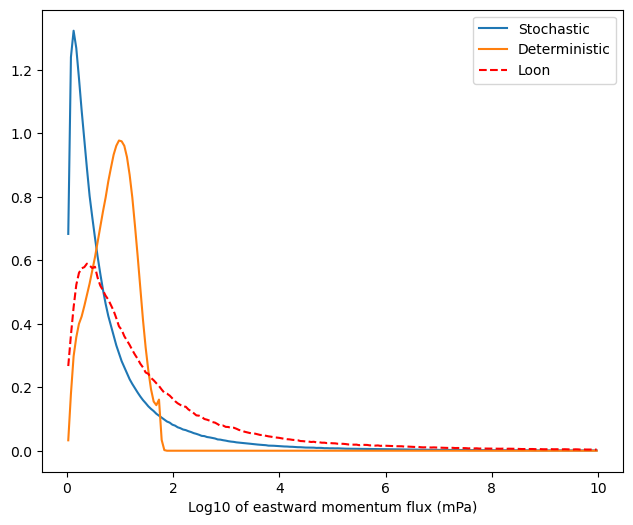

In [14]:
fig,ax = plt.subplots(1,1,figsize=(7.5,6))
bin_edge= np.linspace(0,10,200,endpoint=True)
bin_center = 0.5*(bin_edge[1:] + bin_edge[:-1])

flux_bin, flux_edge = np.histogram(eastward_flux_stoch_gcm,bins=bin_edge,density=True)
determ_flux_bin, _ = np.histogram(eastward_flux_determ_gcm,bins=bin_edge,density=True)

ax.plot(bin_center,flux_bin,label='Stochastic')
ax.plot(bin_center,determ_flux_bin,label='Deterministic')
ax.set_xlabel("Log10 of eastward momentum flux (mPa)")
flux_bin, _ = np.histogram(LOON_DATA['u_flux_ptv'],bins=bin_edge,density=True)
ax.plot(bin_center,flux_bin,color='red',linestyle='--',label="Loon")
plt.legend()
plt.savefig(f'figures/{expcode}_stochastic_gcm_norm.png')